In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import logging
import torch.utils.data as utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Pretrain an AE

In [2]:
class BaseNet(nn.Module):
    """Base class for all neural networks."""

    def __init__(self):
        super().__init__()
        self.logger = logging.getLogger(self.__class__.__name__)
        self.rep_dim = None  # representation dimensionality, i.e. dim of the code layer or last layer                                                                             

    def forward(self, *input):
        """                                                                                                                                                                        
        Forward pass logic                                                                                                                                                         
        :return: Network output                                                                                                                                                    
        """
        raise NotImplementedError

    def summary(self):
        """Network summary."""
        net_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in net_parameters])
        self.logger.info('Trainable parameters: {}'.format(params))
        self.logger.info(self)

In [3]:
class Linear_BN_leakyReLU(nn.Module):
    """                                                                                                                                                                            
    A nn.Module that consists of a Linear layer followed by BatchNorm1d and a leaky ReLu activation                                                                                
    """

    def __init__(self, in_features, out_features, bias=False, eps=1e-04):
        super(Linear_BN_leakyReLU, self).__init__()

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.bn = nn.BatchNorm1d(out_features, eps=eps, affine=bias)

    def forward(self, x):
        return F.leaky_relu(self.bn(self.linear(x)))

In [4]:
class MLP(BaseNet):

    def __init__(self, x_dim, h_dims=[128, 64], rep_dim=3, bias=False):
        super().__init__()

        self.rep_dim = rep_dim

        neurons = [x_dim, *h_dims]
        layers = [Linear_BN_leakyReLU(neurons[i - 1], neurons[i], bias=bias) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(layers)
        self.code = nn.Linear(h_dims[-1], rep_dim, bias=bias)

    def forward(self, x):
        x = x.view(int(x.size(0)), -1)
        for layer in self.hidden:
            x = layer(x)
        return self.code(x)

In [5]:
class MLP_Decoder(BaseNet):

    def __init__(self, x_dim, h_dims=[64, 128], rep_dim=3, bias=False):
        super().__init__()

        self.rep_dim = rep_dim

        neurons = [rep_dim, *h_dims]
        layers = [Linear_BN_leakyReLU(neurons[i - 1], neurons[i], bias=bias) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(layers)
        self.reconstruction = nn.Linear(h_dims[-1], x_dim, bias=bias)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = x.view(int(x.size(0)), -1)
        for layer in self.hidden:
            x = layer(x)
        x = self.reconstruction(x)
        return self.output_activation(x)

In [6]:
x_dim, h_dims, rep_dim, bias = 12,[40,30,20,10],3, False
model_enc = MLP(x_dim, h_dims, rep_dim, bias).cuda()
model_dec = MLP_Decoder(x_dim, list(reversed(h_dims)), rep_dim, bias).cuda()

In [7]:
lhc_data = np.array(pd.read_hdf("Nsubjettiness_RandD_normalized.h5"))

In [8]:
X = lhc_data[:,1:-1]
y = lhc_data[:,-1]

In [9]:
for i in range(len(X[0])):
    X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))

In [10]:
idx_norm = y == 0
idx_out = y == 1

In [11]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X[idx_norm], y[idx_norm],test_size=0.2)
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X[idx_out], y[idx_out],test_size=0.2)

In [12]:
X_train = np.concatenate((X_train_norm, X_train_out))
X_test = np.concatenate((X_test_norm, X_test_out))
y_train = np.concatenate((y_train_norm, y_train_out))
y_test = np.concatenate((y_test_norm, y_test_out))

In [13]:
known_idx_train = np.where(y_train==1)[0]
power_labels = np.ones(len(y_train))
power_labels[known_idx_train]=-1

In [14]:
X_train = torch.tensor(X_train).float().cuda()
X_test = torch.tensor(X_test).float().cuda()
y_train = torch.tensor(y_train).float().cuda()
y_test = torch.tensor(y_test).float().cuda()
power_labels = torch.tensor(power_labels).float().cuda()
power_labels = power_labels.view(len(power_labels),1)

In [15]:
# use power labels instead of the real labels
training_dataset = utils.TensorDataset(X_train,power_labels) 
training_dataloader = utils.DataLoader(training_dataset, batch_size=2048, shuffle=True)

In [16]:
n_epochs = 360
lrs = 3e-3
loss_f = nn.MSELoss()

In [ ]:
for epoch in range(n_epochs):
    if epoch%40==0:
        lrs = lrs/3
        optimizer_enc = optim.Adam(model_enc.parameters(), lr = lrs, weight_decay=5e-4)
        optimizer_dec = optim.Adam(model_dec.parameters(), lr = lrs, weight_decay=5e-4)
    model_enc.train()
    model_dec.train()
    
    for i, data in enumerate(training_dataloader):
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        
        x_pred = model_dec(model_enc(data[0]))
        
        loss = torch.sqrt(loss_f(x_pred,data[0])/torch.mean(data[0]**2))
#         loss = loss_f(x_pred,data[0])
        loss.backward()
        
        optimizer_enc.step()
        optimizer_dec.step()
    print(epoch, lrs, loss.detach().cpu().numpy())

In [ ]:
# torch.save(model_enc.state_dict(), "weights/AE_encoder.h5")
# torch.save(model_dec.state_dict(), "weights/AE_decoder.h5")

In [17]:
model_enc.load_state_dict(torch.load("weights/AE_encoder.h5"))
model_dec.load_state_dict(torch.load("weights/AE_decoder.h5"))

<All keys matched successfully>

## Test time

In [18]:
test_dataset = utils.TensorDataset(X_test,y_test) 
test_dataloader = utils.DataLoader(test_dataset, batch_size=2048)

In [19]:
model_dec.eval()
model_enc.eval()
losses = np.array([])
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        x_pred = x_pred = model_dec(model_enc(data[0]))
        loss =  torch.mean((x_pred-data[0])**2,axis=1)
        losses = np.append(losses,loss.detach().cpu().numpy())

In [20]:
losses_sig = losses[np.where(y_test.detach().cpu().numpy()==1)]
losses_bkg = losses[np.where(y_test.detach().cpu().numpy()==0)]

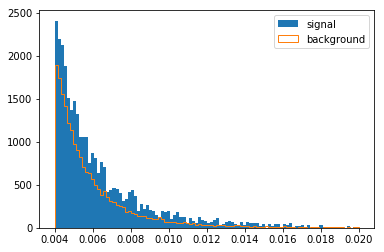

In [21]:
plt.hist(losses_sig,100,range=[0.004,0.02],weights=np.ones(len(losses_sig))*len(losses_bkg)/len(losses_sig),label="signal");
plt.hist(losses_bkg,100,range=[0.004,0.02],histtype="step",label="background");
plt.legend();

## Add sphere in latent space

In [22]:
model_enc_sphere = MLP(x_dim, h_dims, rep_dim, bias).cuda()
model_dec_sphere = MLP_Decoder(x_dim, list(reversed(h_dims)), rep_dim, bias).cuda()

In [23]:
model_enc_sphere.load_state_dict(torch.load("weights/AE_encoder.h5"))
model_dec_sphere.load_state_dict(torch.load("weights/AE_decoder.h5"))

<All keys matched successfully>

In [24]:
lat_space = np.array([0,0,0])
with torch.no_grad():
    for i, data in enumerate(training_dataloader):
        lat = model_enc_sphere(data[0])
        lat_space = np.row_stack([lat_space,torch.mean(lat,0).detach().cpu().numpy()])

In [25]:
lat_space = lat_space[1:]

In [26]:
sphere_center = np.array([np.mean(lat_space[:,0]),np.mean(lat_space[:,1]),np.mean(lat_space[:,2])])

In [27]:
sphere_center = torch.tensor(sphere_center).float().cuda()
sphere_center

tensor([0.1093, 0.0499, 0.1183], device='cuda:0')

In [28]:
n_epochs = 200
lrs = 1e-4
loss_f = nn.MSELoss()

In [58]:
!pwd

/home/paperspace/fastai/courses/Tegmark_project_2/normalizing_flows_for_lhc_29_Jan/analysis_may_2020/Deep-SAD-PyTorch/data


In [29]:
for epoch in range(n_epochs):
    if epoch%20==0:
        lrs = lrs/3
        optimizer_enc = optim.Adam(model_enc_sphere.parameters(), lr = lrs, weight_decay=5e-4)
    model_enc_sphere.train()
    
    for i, data in enumerate(training_dataloader):
        optimizer_enc.zero_grad()        
        
        loss = torch.mean((model_enc_sphere(data[0])-sphere_center)**(2*data[1]))
        loss.backward()
        
        optimizer_enc.step()
    print(epoch, lrs, loss.detach().cpu().numpy())

0 3.3333333333333335e-05 103.73647
1 3.3333333333333335e-05 52.82835
2 3.3333333333333335e-05 3161.7144
3 3.3333333333333335e-05 24.192394
4 3.3333333333333335e-05 268.59335
5 3.3333333333333335e-05 22.9772
6 3.3333333333333335e-05 331.22614
7 3.3333333333333335e-05 96.869896
8 3.3333333333333335e-05 49683.184
9 3.3333333333333335e-05 25.78176
10 3.3333333333333335e-05 117.4273
11 3.3333333333333335e-05 2853.694
12 3.3333333333333335e-05 58.274868
13 3.3333333333333335e-05 72.342865
14 3.3333333333333335e-05 28.801168
15 3.3333333333333335e-05 36.26664
16 3.3333333333333335e-05 1128.4102
17 3.3333333333333335e-05 71.022804
18 3.3333333333333335e-05 319.05423
19 3.3333333333333335e-05 275.86264
20 1.1111111111111112e-05 98.95187
21 1.1111111111111112e-05 702.239
22 1.1111111111111112e-05 626.74536
23 1.1111111111111112e-05 55.465324
24 1.1111111111111112e-05 34.94226
25 1.1111111111111112e-05 43.380013
26 1.1111111111111112e-05 39.887844
27 1.1111111111111112e-05 32.907036
28 1.11111111

In [ ]:
# torch.save(model_enc_sphere.state_dict(), "weights/AE_encoder_sphere.h5")
# torch.save(model_dec_sphere.state_dict(), "weights/AE_decoder_sphere.h5")

In [ ]:
model_enc_sphere.load_state_dict(torch.load("weights/AE_encoder_sphere.h5"))
model_dec_sphere.load_state_dict(torch.load("weights/AE_decoder_sphere.h5"))

## Test time again

In [30]:
model_enc_sphere.eval()
model_dec_sphere.eval()
losses = np.array([])
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        x_pred = x_pred = model_dec_sphere(model_enc_sphere(data[0]))
        loss =  torch.mean((x_pred-data[0])**2,axis=1)
        losses = np.append(losses,loss.detach().cpu().numpy())

In [31]:
losses_sig = losses[np.where(y_test.detach().cpu().numpy()==1)]
losses_bkg = losses[np.where(y_test.detach().cpu().numpy()==0)]

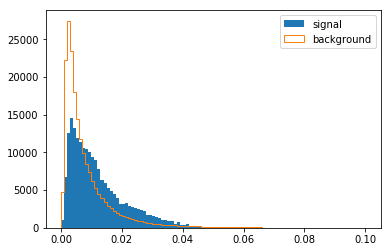

In [37]:
plt.hist(losses_sig,100,range=[0,0.1],weights=np.ones(len(losses_sig))*len(losses_bkg)/len(losses_sig),label="signal");
plt.hist(losses_bkg,100,range=[0,0.1],histtype="step",label="background");
plt.legend();

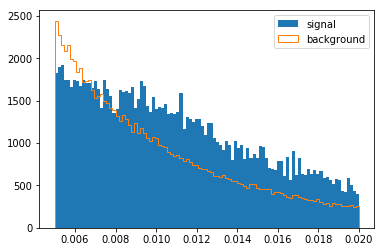

In [38]:
plt.hist(losses_sig,100,range=[0.005,0.02],weights=np.ones(len(losses_sig))*len(losses_bkg)/len(losses_sig),label="signal");
plt.hist(losses_bkg,100,range=[0.005,0.02],histtype="step",label="background");
plt.legend();

## Check latent space

In [39]:
model_enc_sphere.eval()
model_dec_sphere.eval()
latents = np.array([0,0,0])
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        lat =  model_enc_sphere(data[0])
        latents = np.row_stack([latents,lat.detach().cpu().numpy()])

In [40]:
latents = latents[1:]

In [41]:
latents_sig = latents[np.where(y_test.detach().cpu().numpy()==1)]
latents_bkg = latents[np.where(y_test.detach().cpu().numpy()==0)]

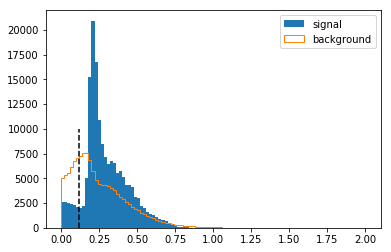

In [44]:
i = 2
plt.hist(latents_sig[:,i],100,range=[0,2],weights=np.ones(len(losses_sig))*len(losses_bkg)/len(losses_sig),label="signal");
plt.hist(latents_bkg[:,i],100,range=[0,2],histtype="step",label="background");
plt.plot([sphere_center[i],sphere_center[i]],[0,10000],"k--")
plt.legend();